## Analysis of Toolwindow Usage Data

The aim of this analysis is to test whether there is a significant (statistical!!) difference in how long a tool window stays open based on how it was opened. I've divided this task into three main parts:
- Data cleaning: cleaning our data for further analysis.
- Reconstruction of episodes of toolwindow usage and calculating the duration of it being opened
- Comparison durations distribution/patterns between automatic and manual opens

Libraries needed for this task:
- `pandas`
- `MatPlotLib`
- `scipy`

**How to run the code?** Make sure all libraries listed above are installed in the environment you are working in. Then run every cell in exact order that it is given. Hope everything is clear and readable.

In [147]:
import pandas as pd

### 1. Data cleaning

In [148]:
url = 'https://raw.githubusercontent.com/youngopos/JetBrains-Project/refs/heads/main/toolwindow_data.csv'
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
df_clean = df.sort_values(['user_id','timestamp']).reset_index(drop=True)

In [149]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  3503 non-null   datetime64[ns]
 1   event      3503 non-null   object        
 2   open_type  1865 non-null   object        
 3   user_id    3503 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 109.6+ KB


In [150]:
df_clean.head(100)

,timestamp,event,open_type,user_id
0,2025-07-06 18:21:42.123,opened,auto,1
1,2025-07-06 18:32:26.077,closed,NaN,1
2,2025-07-06 22:34:18.635,opened,manual,1
3,2025-07-07 00:52:24.609,closed,NaN,1
4,2025-07-08 14:38:07.772,opened,manual,1
...,...,...,...,...
95,2025-07-07 11:50:32.857,opened,auto,5
96,2025-07-07 13:33:09.558,closed,NaN,5
97,2025-07-07 13:33:10.322,opened,manual,5
98,2025-07-07 14:23:14.474,closed,NaN,5


### 2. Main objective: reconstruction of episodes of tool window usage and calculating durations

In [151]:
episodes = []

for user, group in df_clean.groupby('user_id', sort=False):
    group = group.sort_values('timestamp')

    open_time = None
    open_kind = None

    for _, record in group.iterrows():
        if record['event'] == 'opened':
            if open_time is None:
                open_time = record['timestamp']
                open_kind = record['open_type']
        elif record['event'] == 'closed':
            if open_time is not None:
                duration = (record['timestamp'] - open_time).total_seconds()
                if duration >= 0:
                    episodes.append({
                        'user_id': user,
                        'opened_at': open_time,
                        'closed_at': record['timestamp'],
                        'open_type': open_kind,
                        'duration[seconds]': duration
                    })
                open_time = None
                open_kind = None
logs_time_duration = pd.DataFrame(episodes)

In [152]:
logs_time_duration.head(100)

,user_id,opened_at,closed_at,open_type,duration[seconds]
0,1,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077,auto,643.954
1,1,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609,manual,8285.974
2,1,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885,manual,1136.113
3,1,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,manual,0.748
4,1,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775,manual,7227.188
...,...,...,...,...,...
95,7,2025-07-21 20:19:22.426,2025-07-22 04:19:50.844,auto,28828.418
96,7,2025-07-22 06:10:33.228,2025-07-22 09:02:37.959,auto,10324.731
97,7,2025-07-22 09:09:39.008,2025-07-23 06:03:49.740,auto,75250.732
98,7,2025-07-23 06:18:31.595,2025-07-23 09:30:39.644,auto,11528.049


In [153]:
logs_time_duration['duration[seconds]'].describe()

count      1622.000000
mean      11595.114041
std       59191.892847
min           0.015000
25%          10.816000
50%         106.670500
75%         801.588000
max      896588.154000
Name: duration[seconds], dtype: float64

#### 2.1 Converting duration time to minutes instead of seconds

In [154]:
logs_time_duration['duration[seconds]'] = logs_time_duration['duration[seconds]']/60
logs_time_duration = logs_time_duration.rename(columns={
    'duration[seconds]': 'duration[mins]'
})

In [155]:
logs_time_duration['duration[mins]'].describe()

count     1622.000000
mean       193.251901
std        986.531547
min          0.000250
25%          0.180267
50%          1.777842
75%         13.359800
max      14943.135900
Name: duration[mins], dtype: float64

#### 2.2 Filtering data removing outliers (we're keeping 99% of the records)

In [156]:
quantile99 = logs_time_duration['duration[mins]'].quantile(0.99)
# quantile01 = logs_time_duration['duration[mins]'].quantile(0.01)

logs_time_duration = logs_time_duration.loc[
    #(logs_time_duration['duration[mins]'] > quantile01) &
    (logs_time_duration['duration[mins]'] < quantile99)
]

In [157]:
logs_time_duration['duration[mins]'].describe()

count    1605.000000
mean      109.667091
std       454.463087
min         0.000250
25%         0.176133
50%         1.713500
75%        12.312583
max      4248.552400
Name: duration[mins], dtype: float64

In [158]:
logs_time_duration.groupby('open_type')['duration[mins]'].describe()

,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,975.0,147.723634,516.510099,0.002567,0.659008,3.517567,23.048592,4180.891483
manual,630.0,50.770059,328.413477,0.000250,0.038233,0.230500,2.676483,4248.552400


### 3. Manual vs auto: Comparison

#### 3.1 Visualization

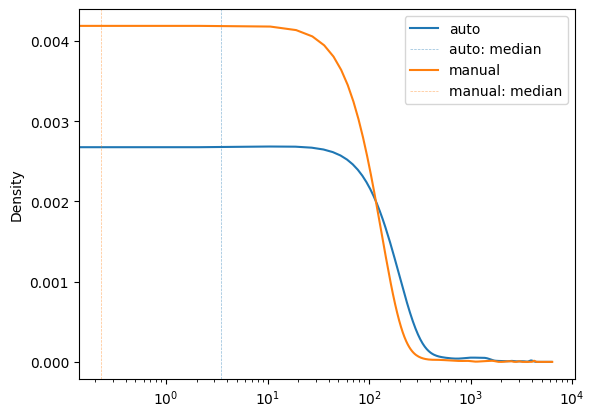

In [162]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for label,g in logs_time_duration.groupby('open_type'):
    g['duration[mins]'].plot(kind = 'kde',
                             ax = ax, label=label)

    median = g['duration[mins]'].median()
    mean = g['duration[mins]'].mean()
    q05 = g['duration[mins]'].quantile(0.05)
    q95 = g['duration[mins]'].quantile(0.95)

    ax.axvline(median, color=ax.get_lines()[-1].get_color(),
               linewidth = 0.5,
               alpha = 0.5,
               linestyle = '--',
               label = f'{label}: median'
               )
    # ax.axvline(median, color=ax.get_lines()[-1].get_color())
    # ax.axvline(q05, color=ax.get_lines()[-1].get_color())
    # ax.axvline(q95, color=ax.get_lines()[-1].get_color())

ax.set_xscale('log')
ax.legend()
plt.show()

#### 3.2 Statistical Significance test

In [160]:
## Mann–Whitney U test

from scipy.stats import mannwhitneyu

manual = logs_time_duration.loc[logs_time_duration['open_type'] == 'manual']
auto = logs_time_duration.loc[logs_time_duration['open_type'] == 'auto']

u_stat, p_value = mannwhitneyu(manual['duration[mins]'], auto['duration[mins]'])

#### 3.2.1 p-value

In [163]:
p_value

np.float64(2.011356325829878e-58)

#### 3.2.2 median difference

In [145]:
auto['duration[mins]'].median()-manual['duration[mins]'].median()

np.float64(3.2870666666666666)